Not the demo script, won't work with our paths unless you running in our group folder. You can see what the output was last though.

This script was used to test all the models by getting the output for every model for an input landscape image from the iterator. We just repeatedly run the iterator and look at the result that gets saved. 
Then we also got results for monet paintings to landscape with three different models, and a cezanne paintings with identity. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib notebook
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import time
import random


In [0]:
!cp 'gdrive/Team Drives/ECE 285/network.py' .
import network as net #discriminators and generators from renjie in network.py 

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [0]:
class MyImageFolder(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index]

In [0]:
#have to split train and test outselves probably. 
def getDataset(path,image_size=(256,256)):
    transform = tv.transforms.Compose([
        tv.transforms.Resize(image_size,Image.LANCZOS),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        
        ])

    dataset = MyImageFolder(path,transform) #what I downloaded
    return dataset
    

In [0]:
landscapes_train= getDataset('gdrive/Team Drives/ECE 285/landscape_photos/train')
landscapes_test= getDataset('gdrive/Team Drives/ECE 285/landscape_photos/test')


In [0]:
landscape_loader = td.DataLoader(landscapes_train, batch_size=1,shuffle=True, pin_memory=True)
landscape_loader_test = td.DataLoader(landscapes_test, batch_size=1,shuffle=True, pin_memory=True)

In [0]:
#make iterators for the dataloaders
landscape_itr = iter(landscape_loader)
landscape_test_itr = iter(landscape_loader_test)

## Paths

In [0]:
monet_base = 'gdrive/Team Drives/ECE 285/cyclegan_monet_base'
monet_orig = 'gdrive/Team Drives/ECE 285/cyclegan_monet_base_origdataset'
monet_lowercycle = 'gdrive/Team Drives/ECE 285/cyclegan_monet_lowercycle'
ukiyoe = 'gdrive/Team Drives/ECE 285/cyclegan_ukiyoe_basic'
vangogh_base= 'gdrive/Team Drives/ECE 285/cyclegan_vangogh_basic'
vangogh_noise= 'gdrive/Team Drives/ECE 285/cyclegan_vangogh_noise'
vangogh_noise2= 'gdrive/Team Drives/ECE 285/cyclegan_vangogh_noise2'
shiskin = 'gdrive/Team Drives/ECE 285/Ivan_Shishkin'
cezanne = 'gdrive/Team Drives/ECE 285/Paul_Cezanne'
ident = 'gdrive/Team Drives/ECE 285/ident/10 Ivan_Shishkin'
paths = [monet_base,monet_orig,monet_lowercycle,ukiyoe,vangogh_base,vangogh_noise,vangogh_noise2,shiskin,cezanne,ident]
names = ['monet_base','monet_orig','monet_lowercycle','ukiyoe','vangogh_base','vangogh_noise','vangogh_noise2','shiskin','cezanne','cezanne ident']

## Loading the Models

In [0]:
def LandscapeToPainting(path):
    Gyx = net.define_G()
    Gyx.load_state_dict(torch.load(path+'/models/gyx_saved_last_200.pt'))    
    return Gyx.to(device).eval()

In [0]:
def PaintingToLandscape(path):
    Gxy = net.define_G()
    Gxy.load_state_dict(torch.load(path+'/models/gxy_saved_last_200.pt'))    
    return Gxy.to(device).eval()

## Testing Landscape to Painting Models

In [0]:
next_ = landscape_itr.next()
train_landscape = next_[0][0].to(device)
train_landscape_name = str(os.path.basename(next_[1][0][0])).split('.')[0]+ '_'

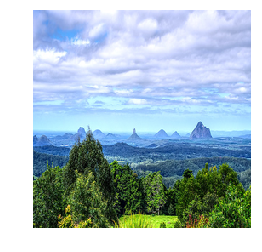

In [59]:
myimshow(train_landscape[0])

In [0]:
next_ = landscape_test_itr.next()
test_landscape = next_[0][0].to(device)
test_landscape_name = str(os.path.basename(next_[1][0][0])).split('.')[0] + '_'

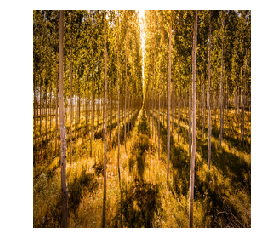

In [69]:
myimshow(test_landscape[0])

In [0]:
savetest_dir = 'gdrive/Team Drives/ECE 285/testing_models/test/'

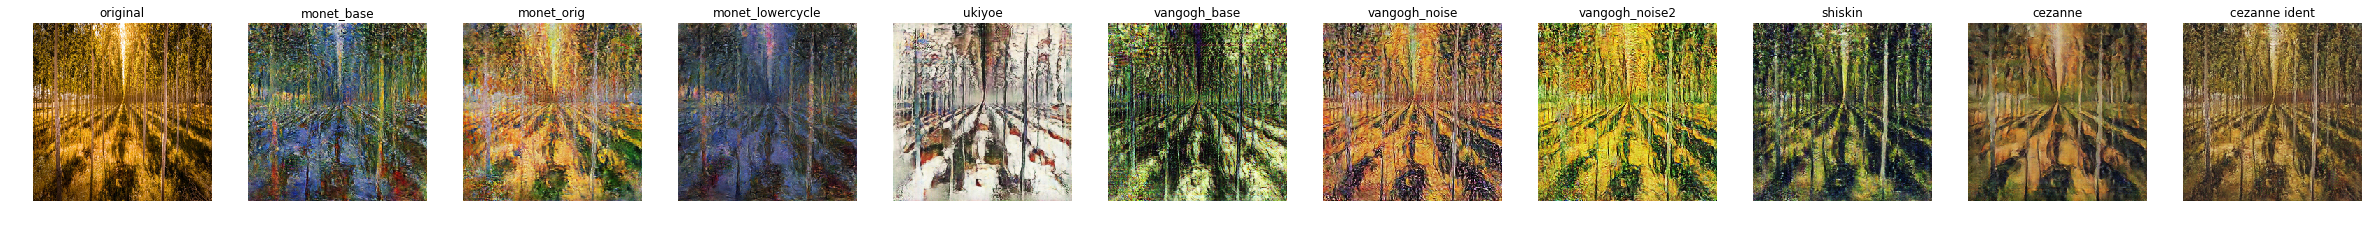

In [71]:
i = 1
test = test_landscape
f, axes = plt.subplots(1,len(paths)+1,figsize=(3*(len(paths)+1),2*(len(paths)+1)))
myimshow(test_landscape[0], ax=axes[0])
axes[0].set_title('original')
for path in paths:
    Gyx = LandscapeToPainting(path)
    with torch.no_grad():
        output = Gyx(test).detach()
        myimshow(output[0], ax=axes[i])
        axes[i].set_title(names[i-1])
        plt.tight_layout()
        f.canvas.draw()
        tv.utils.save_image(output[0],savetest_dir+test_landscape_name+names[i-1]+'.jpg', normalize=True)
    i+=1
f.savefig(savetest_dir+test_landscape_name+'all.jpg', bbox_inches='tight')
    

In [0]:
savetrain_dir = 'gdrive/Team Drives/ECE 285/testing_models/train/'


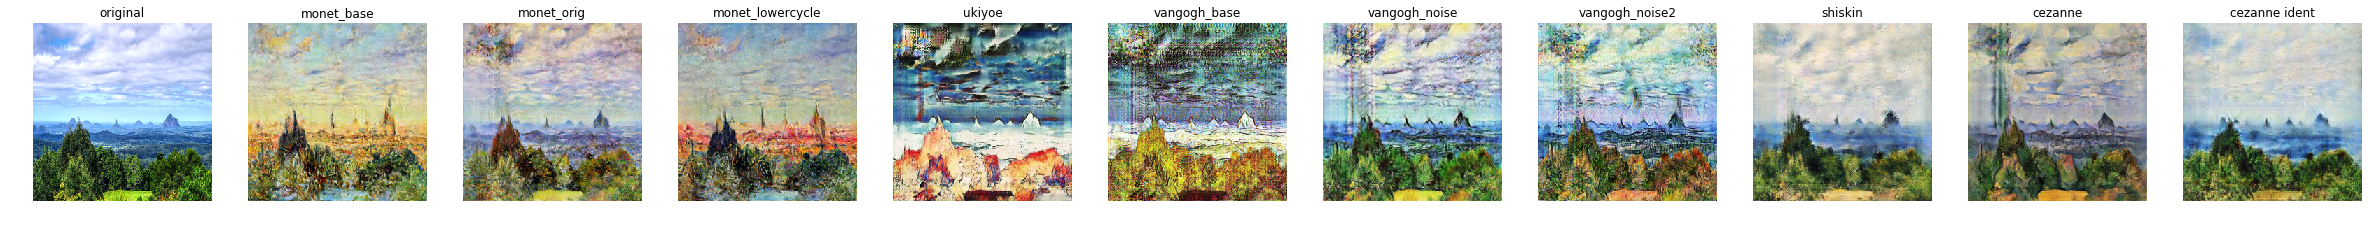

In [63]:
i = 1
test = train_landscape
f, axes = plt.subplots(1,len(paths)+1,figsize=(3*(len(paths)+1),2*(len(paths)+1)))
myimshow(train_landscape[0], ax=axes[0])
axes[0].set_title('original')
for path in paths:
    Gyx = LandscapeToPainting(path)
    with torch.no_grad():
        output = Gyx(test).detach()
        myimshow(output[0], ax=axes[i])
        axes[i].set_title(names[i-1])
        plt.tight_layout()
        f.canvas.draw()
        tv.utils.save_image(output[0],savetrain_dir+train_landscape_name+names[i-1]+'.jpg', normalize=True)
    i+=1
f.savefig(savetrain_dir+train_landscape_name+'all.jpg', bbox_inches='tight')

# Testing Painting to Landscape

## Monet with different dataset and lambda for cycle loss

In [0]:
save_painting = 'gdrive/Team Drives/ECE 285/testing_models/paint2photo/'
save_monet = save_painting +'monet/'
save_cezanne = save_painting +'cezanne/'

In [0]:
monet_paths = [monet_base,monet_orig,monet_lowercycle]
monet_names = ['monet_base','monet_orig','monet_lowercycle']

In [0]:
monet_paintings= getDataset('gdrive/Team Drives/ECE 285/monet2photo/monet2photo/paintings')
monet_loader = td.DataLoader(monet_paintings, batch_size=1,shuffle=True, pin_memory=True)


In [0]:
monet_itr = iter(monet_loader)

In [0]:
next_monet = monet_itr.next()
monet_painting = next_monet[0][0].to(device)
monet_painting_id = str(os.path.basename(next_monet[1][0][0])).split('.')[0]+ '_'

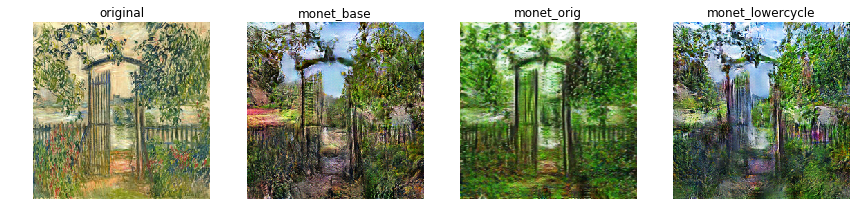

In [44]:
i = 1
f, axes = plt.subplots(1,len(monet_paths)+1,figsize=(3*(len(monet_paths)+1),2*(len(monet_paths)+1)))
myimshow(monet_painting[0], ax=axes[0])
axes[0].set_title('original')
for path in monet_paths:
    Gxy = PaintingToLandscape(path)
    with torch.no_grad():
        output = Gxy(monet_painting).detach()
        myimshow(output[0], ax=axes[i])
        axes[i].set_title(monet_names[i-1])
        plt.tight_layout()
        f.canvas.draw()
        tv.utils.save_image(output[0],save_monet+monet_painting_id+monet_names[i-1]+'.jpg', normalize=True)
    i+=1
f.savefig(save_monet+monet_painting_id+'all.jpg', bbox_inches='tight')

## Cezanne with identity

In [0]:
cezanne_paths = [cezanne,ident]
cezanne_names = ['cezanne','cezanne_ident']
cezanne_paintings= getDataset('gdrive/Team Drives/ECE 285/cezanne2photo/cezanne2photo/paintings')
cezanne_loader = td.DataLoader(cezanne_paintings, batch_size=1,shuffle=True, pin_memory=True)

In [0]:
cezanne_itr = iter(cezanne_loader)

In [0]:
next_cezanne= cezanne_itr.next()
cezanne_painting = next_cezanne[0][0].to(device)
cezanne_painting_id = str(os.path.basename(next_cezanne[1][0][0])).split('.')[0]+ '_'

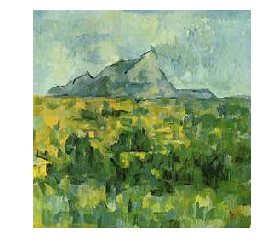

In [489]:
myimshow(cezanne_painting[0])

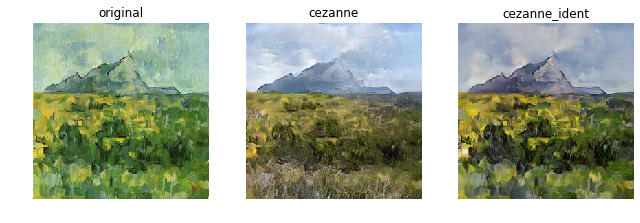

In [490]:
i = 1
f, axes = plt.subplots(1,len(cezanne_paths)+1,figsize=(3*(len(cezanne_paths)+1),2*(len(cezanne_paths)+1)))
myimshow(cezanne_painting[0], ax=axes[0])
axes[0].set_title('original')
for path in cezanne_paths:
    Gxy = PaintingToLandscape(path)
    with torch.no_grad():
        output = Gxy(cezanne_painting).detach()
        myimshow(output[0], ax=axes[i])
        axes[i].set_title(cezanne_names[i-1])
        plt.tight_layout()
        f.canvas.draw()
        tv.utils.save_image(output[0],save_cezanne+cezanne_painting_id+cezanne_names[i-1]+'.jpg', normalize=True)
    i+=1
f.savefig(save_cezanne+cezanne_painting_id+'all.jpg', bbox_inches='tight')